# Packages needed and hardware

In [32]:
#import the required functions
from bingham import *

#Packages and Hardware
%load_ext watermark
#python, ipython, packages and machine characteristics
%watermark -v -m -p numpy,matplotlib,scipy,pandas,random,mplstereonet,watermark

#date
print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
matplotlib 2.2.2
scipy 1.1.0
pandas 0.23.0
random unknown
mplstereonet 0.5
watermark 2.0.2

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
 
last updated: Tue Mar 17 2020 16:06:56 New Zealand Daylight Time


# Generate 2 clusters

In [14]:
# Generate a random scatter of planes around the given plane
# All measurements follow the right-hand-rule to indicate dip direction
strike1, dip1 = 50, 10
num = 400
strikesp1 = strike1 + 10 * np.random.randn(num) #10
dipsp1 = dip1 + 30 * np.random.randn(num)

#Find the average pole using linear algebra
w1,E1=axis_poles(strikesp1,dipsp1)

# All measurements follow the right-hand-rule to indicate dip direction
strike2, dip2 = 140, 60
num = 500
strikesp2 = strike2 + 10 * np.random.randn(num)
dipsp2 = dip2 + 50 * np.random.randn(num)

#Find the average pole using linear algebra
w2,E2=axis_poles(strikesp2,dipsp2)

## All measurements follow the right-hand-rule to indicate dip direction
#strike3, dip3 = 330, 50
#num = 300
#strikesp3 = strike3 + 10 * np.random.randn(num)
#dipsp3 = dip3 + 10 * np.random.randn(num)

##Find the average pole using linear algebra
#w3,E3=axis_poles(strikesp3,dipsp3)

The Eigenvectors: 
 [[ 0.99023512 -0.13936126  0.00358339]
 [-0.09039109 -0.62228308  0.77755593]
 [ 0.10613129  0.7702871   0.62880358]]
The Eigenvalues: [316.60796026  80.58935086   2.80268888]
The trace of the Eigenvalues should be N (number of points):  399.99999999999994
The Eigenvectors: 
 [[ 0.50137219  0.86518788 -0.00870943]
 [ 0.6553506  -0.38630631 -0.6490632 ]
 [ 0.56492612 -0.31971451  0.76068464]]
The Eigenvalues: [301.98330013 189.76287192   8.25382795]
The trace of the Eigenvalues should be N (number of points):  500.00000000000017


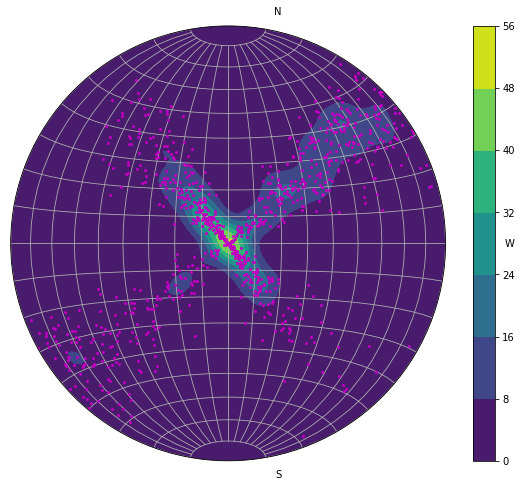

In [15]:
strikesp=np.concatenate([strikesp1,strikesp2])
dipsp=np.concatenate([dipsp1,dipsp2])

fig, ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))

# Create filled contours of the poles of the generated planes...
# By default this uses a modified Kamb contouring technique with exponential
# smoothing (See Vollmer, 1995)
cax = ax.density_contourf(strikesp, dipsp, measurement='poles')

# Plot the poles as points on top of the contours
ax.pole(strikesp, dipsp,color='m',markersize=2)
ax.set_azimuth_ticklabels(['N', '','W', '', 'S', '', 'E', ''])
# Turn on a grid and add a colorbar
ax.grid(True)
fig.colorbar(cax)

# Create a dictionary structure to arrange the data of each cluster

The dictionary structure will hold the data on each cluster and make its retrieval easier for future calculations.  here we create the structure and initialize its values

In [16]:
Clusters ={
#Create a dict structure to store the characteristic values of the clusters
'cluster0' : {
    'E': [], # Principal directions of Bingham distribution
    'K': [], # Density values of Bingham distribution
    'x': [], #5-dimensional vector 
    'lambda': [], #Eigenvalues 
    'N': [], #Number of points in cluster
},

#Create a dict structure to store the characteristic values of a cluster
'cluster1' : {
    'E': [], # Principal directions of Bingham distribution
    'K': [], # Density values of Bingham distribution
    'x': [], #5-dimensional vector 
    'lambda': [], #Eigenvalues 
    'N': [], #Number of points in cluster
},

#Create a dict structure to store the characteristic values of a cluster
'cluster2' : {
    'E': [], # Principal directions of Bingham distribution
    'K': [], # Density values of Bingham distribution
    'x': [], #5-dimensional vector 
    'lambda': [], #Eigenvalues 
    'N': [], #Number of points in cluster
}
}



# 1) Choose $k$ random positions and initialize the clusters

Add values to the dictionary structure using the spherical code of Yamaji & Sato (2006).

In [17]:
# Read Hypersphere csv file with the 5-dimensional vector of coordinates
data = pd.read_csv("E080497cood.csv",header=None) #No header in the DataFrame

kn=2 #len(Clusters)
for i in range(0,kn):
    pos=random.randint(0,len(data)-1) #random position of row in the file
    x=data.iloc[pos]
    k1,k2,E=sy_vec2matrices(x)
    #Fill values
    Clusters['cluster'+np.str(i)+'']['x']=x
    Clusters['cluster'+np.str(i)+'']['E']=E
    Clusters['cluster'+np.str(i)+'']['K']=[k1,k2]
    #plot_bingham(E,k1,k2)
    
del data #release some memory

# 2) From the probabilities calculate the memberships

For the iteration $i$ on each cluster $k$, the membership for a set of parameter $x={E,K}$ is

$$ ^iZ_n^k = \frac{P_B(v_n | ^ix^k)}{\sum_{k=1}^{kn}P_B(v_n | ^ix^k)}$$

In [18]:
kn=2 #len(Clusters)
N=len(strikesp)
PB=np.zeros((N,kn))

#Calculate the Bingham probability distributions
for i in range(0,kn):
    E=Clusters['cluster'+np.str(i)+'']['E']
    k1=Clusters['cluster'+np.str(i)+'']['K'][0]
    k2=Clusters['cluster'+np.str(i)+'']['K'][1]
    PB[:,i]=prob_bingham_sd(E,k1,k2,strikesp,dipsp)

Z=np.zeros((N,kn))
SumP=np.sum(PB,axis=1)
#Calculate the membership values
for i in range(0,kn):
    Z[:,i]=PB[:,i]/SumP

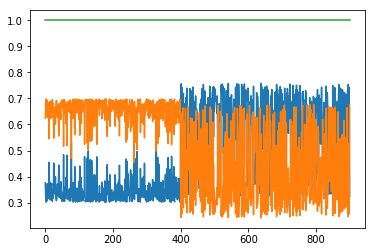

In [19]:
plt.plot(Z[:,0])
plt.plot(Z[:,1])
#plt.plot(Z[:,2])
plt.plot(np.sum(Z,axis=1))

In [20]:
PB.shape

(900, 2)

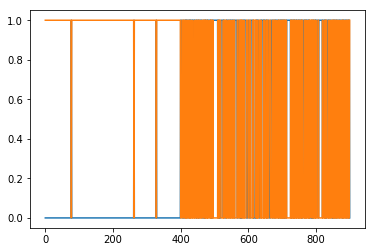

In [21]:
plt.plot(np.argsort(Z))

# 3) Find the membership by finding the maximum probability value

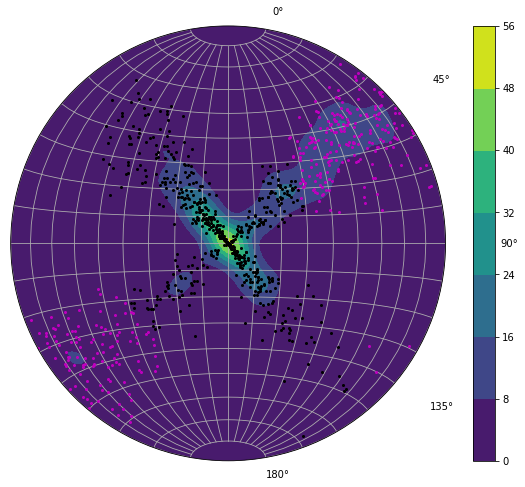

In [22]:
#Decide the membership using the maximum probability criterion
M=np.argmax(Z,axis=1) #M has numbers between 0 and kn-1

#Plot the clusters
fig, ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))

# Create filled contours of the poles of the generated planes...
# By default this uses a modified Kamb contouring technique with exponential
# smoothing (See Vollmer, 1995)
cax = ax.density_contourf(strikesp, dipsp, measurement='poles')

# Plot the poles as points on top of the contours
for i in range(0,kn):
    c=['m','k','g']
    ax.pole(strikesp[M==i], dipsp[M==i],color=c[i],markersize=2)
#ax.set_azimuth_ticklabels(['N', '','W', '', 'S', '', 'E', ''])
# Turn on a grid and add a colorbar
ax.grid(True)
fig.colorbar(cax)

# 4) Calculate the Log-likelihood fit of each 'k-means' cluster

Take the sorted points assigned to each cluster and calculate the best fit of a Bingham distribution to each set. 

In [27]:
#Define the log-likelihood function (set it as negative to be minimize)
def log_likelihood(params):
    k1,k2=params
    #The log-likelihood
    Sum=-num*np.log(4*np.pi)-num*np.log(norm_bingham_onstott(k1,k2))+k1*ws[0]+k2*ws[1] #
    return -Sum 

for i in range(0,kn):
    # Calculate the maximum likelihood
    w,E=axis_poles(strikesp[M==i], dipsp[M==i])
    ws,Es=sort_eig(w,E)
    Clusters['cluster'+np.str(i)+'']['E']=Es
    Clusters['cluster'+np.str(i)+'']['lambda']=ws

    #Fit cluster i
    params0=np.array([-ws[1],-ws[0]])
    res=minimize(log_likelihood,params0,method='Nelder-Mead',options={'disp': True},tol=1e-6)
    k1,k2=res.x
    print('k1 and k2 values',k1,k2)
    print(res.x)
    
    #Update the values in the dictionary
    Clusters['cluster'+np.str(i)+'']['K']=[k1,k2]


The Eigenvectors: 
 [[ 0.29739562  0.95455995 -0.01926534]
 [ 0.72376211 -0.23855812 -0.64750169]
 [ 0.62267508 -0.17862064  0.76182046]]
The Eigenvalues: [282.30071644 112.81718246   7.8821011 ]
The trace of the Eigenvalues should be N (number of points):  403.0000000000002
Optimization terminated successfully.
         Current function value: 431.375035
         Iterations: 69
         Function evaluations: 134
k1 and k2 values -32.33752942636571 -2.6327028431015798
[-32.33752943  -2.63270284]
The Eigenvectors: 
 [[ 0.99497393 -0.10012338  0.00147823]
 [-0.06401295 -0.62463658  0.77828753]
 [ 0.07700142  0.77447043  0.62790631]]
The Eigenvalues: [405.45094854  82.28337079   9.26568067]
The trace of the Eigenvalues should be N (number of points):  497.00000000000006
Optimization terminated successfully.
         Current function value: 377.212958
         Iterations: 68
         Function evaluations: 131
k1 and k2 values -27.62706751133176 -3.6948274085213555
[-27.62706751  -3.6948274

# 5) Repeat (2) the sorting and (3) the membership assignment with the previously calculated likelihood values

After each improvement, re-run the likelihood estimation of the previous cell and repeat this block of code.

## How fast does it converge?

It will depend on the initial conditions.

## Does it make sense?

The sense of the clustering depends on the geological evidence of structures and the exploration experience.  

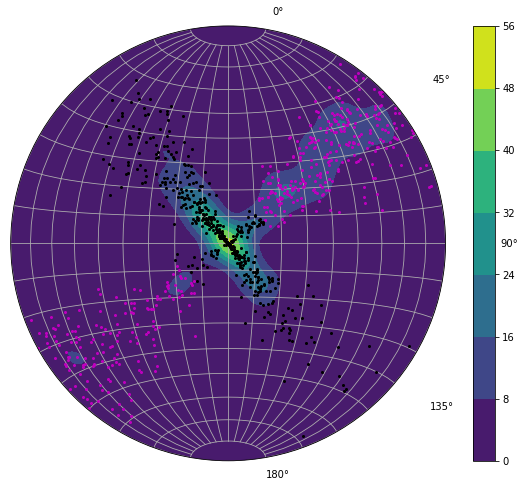

In [28]:
kn=2 #len(Clusters)
N=len(strikesp)
PB=np.zeros((N,kn))

#Calculate the Bingham probability distributions
for i in range(0,kn):
    E=Clusters['cluster'+np.str(i)+'']['E']
    k1=Clusters['cluster'+np.str(i)+'']['K'][0]
    k2=Clusters['cluster'+np.str(i)+'']['K'][1]
    PB[:,i]=prob_bingham_sd(E,k1,k2,strikesp,dipsp)

Z=np.zeros((N,kn))
SumP=np.sum(PB,axis=1)
#Calculate the membership values
for i in range(0,kn):
    Z[:,i]=PB[:,i]/SumP
    
#Decide the membership using the maximum probability criterion
M=np.argmax(Z,axis=1) #M has numbers between 0 and kn-1

#Plot the clusters
fig, ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))

# Create filled contours of the poles of the generated planes...
# By default this uses a modified Kamb contouring technique with exponential
# smoothing (See Vollmer, 1995)
cax = ax.density_contourf(strikesp, dipsp, measurement='poles')

# Plot the poles as points on top of the contours
for i in range(0,kn):
    c=['m','k','g']
    ax.pole(strikesp[M==i], dipsp[M==i],color=c[i],markersize=2)
#ax.set_azimuth_ticklabels(['N', '','W', '', 'S', '', 'E', ''])
# Turn on a grid and add a colorbar
ax.grid(True)
fig.colorbar(cax)